<a href="https://colab.research.google.com/github/rudraxx/pytorch/blob/main/05_fashion_mnist_CNN_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt


In [ ]:
# Load Fashion MNIST data
# Split into train/val set

#Create the dataloaders to get batched data

# Create CNN architecture

# Train model. Run validation per epoch
#Plot the loss


In [ ]:
#Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device} device selected")

cuda device selected


In [ ]:
#Set the Hyperparameters
BATCH_SIZE = 128
EPOCHS=20
LR = 1e-3



In [ ]:
#Load the datasets
#Notes:
#1) Need to get the mean and variance of the dataset.
#2) ToTensor converts the data into the range 0-1 but only after the dataloader is invoked.

transform = transforms.Compose([
    transforms.ToTensor(),
])

#Train dataset
fashion_ds_train = datasets.FashionMNIST(root="root",
                                 train=True,
                                 download=True,
                                 transform=transform)

ds_test = datasets.FashionMNIST(root="root",
                                train=False,
                                 download=True,
                                transform=transform)

print(fashion_ds_train)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: root
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [ ]:
#Get the labels for this dataset
labels_dict = {k:v for k,v in enumerate(fashion_ds_train.classes)}
print(labels_dict)


{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


In [ ]:
#Split into train and validation
ds_train, ds_val = torch.utils.data.random_split(fashion_ds_train,[0.8, 0.2])

#Print the size
print(f"ds_train size = ", {len(ds_train)})
print(f"ds_val size = ", {len(ds_val)})
print(f"ds_test size = ", {len(ds_test)})


ds_train size =  {48000}
ds_val size =  {12000}
ds_test size =  {10000}


In [ ]:
# Create the data loader
dl_train = DataLoader(ds_train,
                      batch_size=BATCH_SIZE,
                      shuffle=True)

dl_val  = DataLoader(ds_val,
                      batch_size=BATCH_SIZE,
                      shuffle=False)

dl_test = DataLoader(ds_test,
                      batch_size=BATCH_SIZE,
                      shuffle=False)



torch.Size([128, 1, 28, 28]) torch.Size([332, 362, 3])


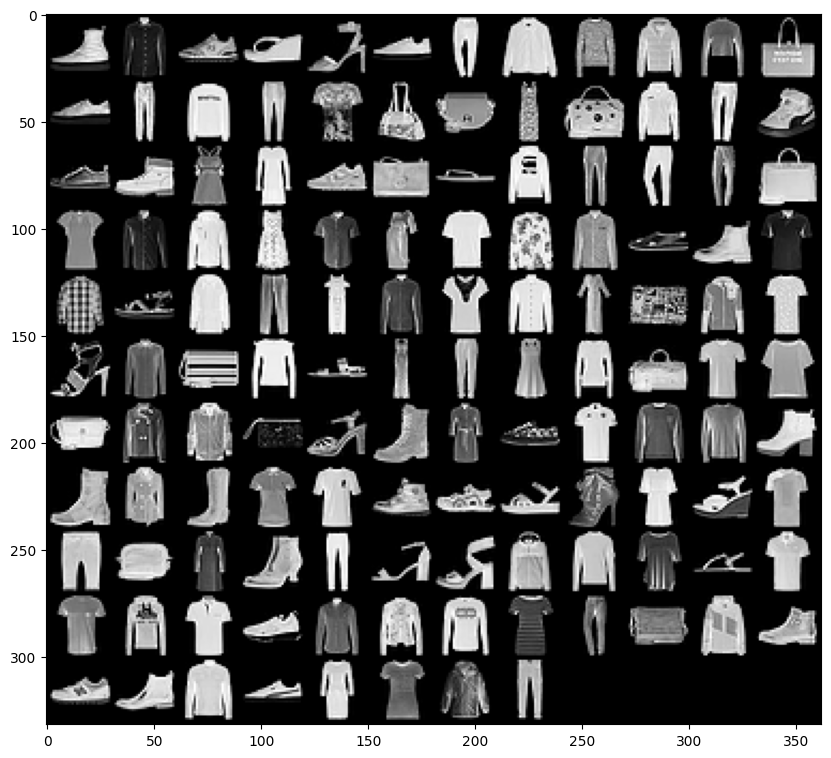

In [ ]:
#Show some of the images
imgs, labels = next(iter(dl_train))

res = make_grid(imgs,nrow=12)
res = res.permute(1,2,0)
print(imgs.shape, res.shape)

plt.figure(figsize=(10,10))
plt.imshow(res)
plt.show()

In [ ]:
print(28*28)

784


# Create the model

For convolutional layers, the output size depends on the kernel size, stride, and padding:

$$\text{Output Size} = \left\lfloor \frac{\text{Input Size} - \text{Kernel Size} + 2 \times \text{Padding}}{\text{Stride}} \right\rfloor + 1$$


In [ ]:
# Create the model
'''
Output Height/Width
=
Input Height/Width
−
Kernel Size
+
2
×
Padding
Stride
+
1
Output Height/Width=
Stride
Input Height/Width−Kernel Size+2×Padding
​
 +1
 '''

class FashionMNIST_CNN(nn.Module):
  def __init__(self, n_layers=1, input_dims=784, input_channels=1):
    super(FashionMNIST_CNN,self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=input_channels,
                  out_channels=16,
                  kernel_size=3,
                  stride=2, padding=1),

        nn.MaxPool2d(2),
        nn.Conv2d(in_channels=16,
                  out_channels=32,
                  kernel_size=3,
                  stride=2, padding=1),
        nn.MaxPool2d(2),
        nn.Flatten()
    )
    self.last = nn.Linear(128,10)


  def forward(self,x):

    x = self.conv1(x)
    output = self.last(x)

    return output

#Test this out
model = FashionMNIST_CNN(n_layers=1, input_dims=28*28, input_channels=1)

x = torch.randn(BATCH_SIZE, 1,28,28)
print(x.shape)

out = model(x)
print(out.shape)


torch.Size([128, 1, 28, 28])
torch.Size([128, 10])


In [ ]:
# Set the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

#Move the model to the device
model.to(device)


FashionMNIST_CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (last): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
# Start the training loop
array_training_loss = []
array_val_loss = []
for epoch in range(EPOCHS):

  running_training_loss = 0

  #Set model in train mode
  model.train()
  for data, labels in dl_train:

    data = data.to(device)
    labels = labels.to(device)

    out = model(data)

    loss = criterion(out,labels)

    # Zero the gradient
    optimizer.zero_grad()

    # calculate the gradients
    loss.backward()

    # Apply the update
    optimizer.step()

    running_training_loss += loss.cpu().item()

  epoch_training_loss = running_training_loss/len(dl_train)

  array_training_loss.append(epoch_training_loss)

  # Get the validation loss

  #Set model in eval mode
  model.eval()

  with torch.no_grad():
    running_val_loss = 0

    for data, labels in dl_val:
      data = data.to(device)
      labels = labels.to(device)

      out = model(data)

      loss = criterion(out,labels)
      running_val_loss += loss.cpu().item()

  epoch_val_loss = running_val_loss/len(dl_val)

  array_val_loss.append(epoch_val_loss)



  print(f"EPOCH {epoch}/{EPOCHS}: training_loss = {epoch_training_loss}, val_loss = {epoch_val_loss}")



EPOCH 0/20: training_loss = 0.8775663496653239, val_loss = 0.6000226124169978
EPOCH 1/20: training_loss = 0.5264964069525401, val_loss = 0.482490950442375
EPOCH 2/20: training_loss = 0.460067033290863, val_loss = 0.48247904536571906
EPOCH 3/20: training_loss = 0.4308853614330292, val_loss = 0.4219457963679699
EPOCH 4/20: training_loss = 0.4054206517537435, val_loss = 0.41124544007346986
EPOCH 5/20: training_loss = 0.3942235637505849, val_loss = 0.40863608600611384
EPOCH 6/20: training_loss = 0.37942607565720876, val_loss = 0.3991318777837652
EPOCH 7/20: training_loss = 0.3678209110101064, val_loss = 0.3792348881351187
EPOCH 8/20: training_loss = 0.3595165778795878, val_loss = 0.3716879043173283
EPOCH 9/20: training_loss = 0.35305328818162285, val_loss = 0.37401654713965476
EPOCH 10/20: training_loss = 0.34499362313747406, val_loss = 0.3710021276740318
EPOCH 11/20: training_loss = 0.33675053528944654, val_loss = 0.3554081864496495
EPOCH 12/20: training_loss = 0.3320536954800288, val_los

In [ ]:
# Get training accuracy
#Set model in eval mode
model.eval()

correct_samples = 0.0
total_samples = 0.0

with torch.no_grad():
  for data, labels in dl_test:
    data = data.to(device)
    labels = labels.to(device)

    out = model(data)

    predicted_label = torch.argmax(out,axis=1)

    correct_samples += torch.sum(predicted_label==labels)
    total_samples += labels.size(0)


print(f"Accuracy on test set = {100.0*correct_samples/total_samples :.2f}%")

Accuracy on test set = 87.94%


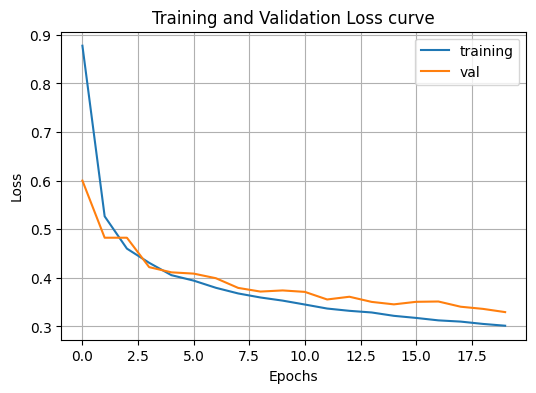

In [ ]:
#Plot the loss curves
import numpy as np

plt.figure(figsize=(6,4))

plt.plot(np.arange(0,EPOCHS), array_training_loss, label="training")
plt.plot(np.arange(EPOCHS), array_val_loss, label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss curve")
plt.grid('on')
plt.legend()

plt.show()

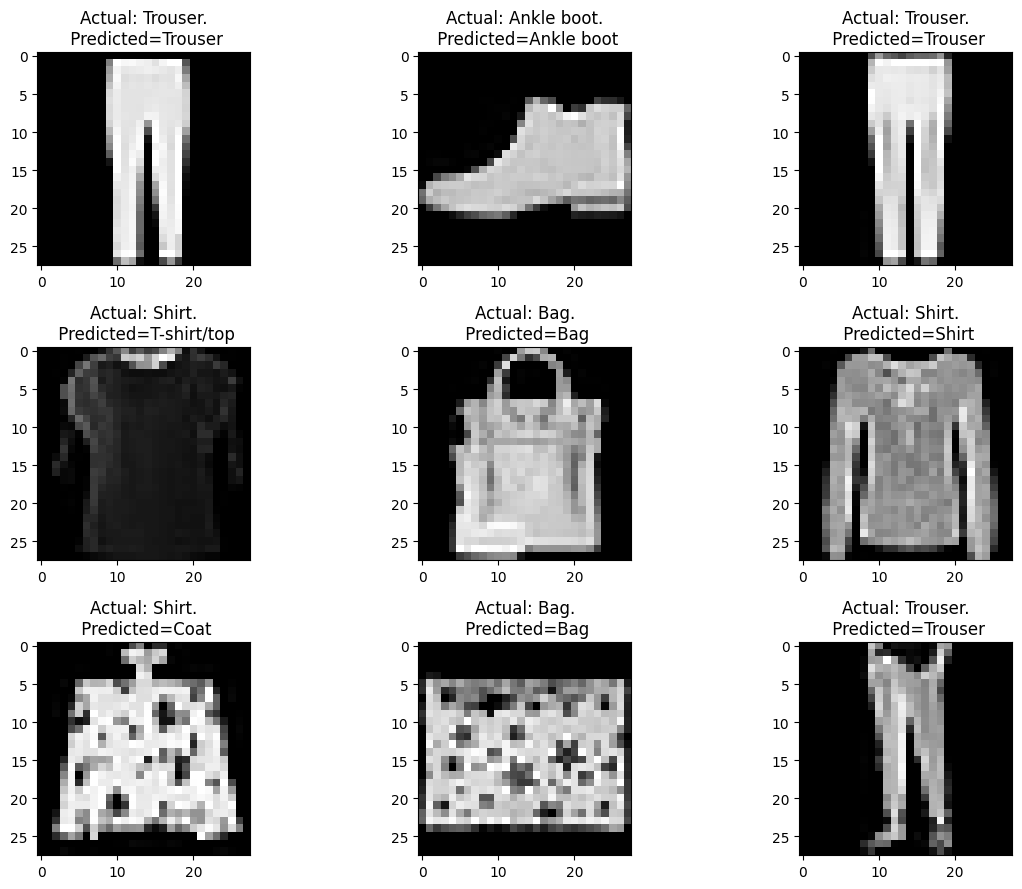

In [ ]:
# Show a few predictions

dl_example = DataLoader(ds_test,batch_size=9,shuffle=True)

images, labels = next(iter(dl_example))

# print(images.shape[0])
#Predict
import matplotlib.gridspec as gridspec

pred_labels = model(images.to(device))
pred_labels = torch.argmax(pred_labels,axis=1)

rows=3
cols=3

figure = plt.figure(figsize=(12,9))
# figure, axes = plt.subplots(3, 3, figsize=(8, 8))

for idx in range(images.shape[0]):

  image = images[idx]
  label = labels[idx].item()
  pred_label = pred_labels[idx].item()
  # print(label, pred_label)

  figure.add_subplot(rows, cols, idx+1)
  plt.imshow(image.permute(1,2,0), cmap='gray')
  plt.title(f"Actual: {labels_dict[label]}.\n Predicted={labels_dict[pred_label]}")

plt.tight_layout()